In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import re
import datatable as dt
import matplotlib.pyplot as plt


In [128]:
fileNames = os.listdir()
print('File names: ')
for file in fileNames:
    if re.match('[a-zA-Z]*.csv',file):
        print('  [+]'+file)

File names: 
  [+]train.csv
  [+]features.csv


# Goal

This competition is evaluated on a **utility score**.  
Each row in the test set represents a trading opportunity for which you will be **predicting an <span style="color:#F5B7B1 ">action</span> value**:  
 * 1 --> to make the trade and  
 * 0 --> to pass on it.   
  
Each trade j has an associated <span style="color:#F5B7B1 "> **weight**</span>  and <span style="color:#F5B7B1 ">**resp**</span>, which represents a return.

For each date i, we define:

$$P_{i} = {\sum weight_{ij} * resp_{}*action_{ij}}.$$
  
  
$$ t = {\sum P_{i} \over \sqrt{\sum P_{i}^2}} * \sqrt{250\over|i|}$$


$$ U = min(max(t, 0), 6)*{\sum p_{i}} $$

where \(|i|\) is the number of unique dates in the test set. The utility is then defined as:

## **Train file info （The 5G file）**

**Size**:  
2390491 rows x 138 columns


**Columns:**

* Feature_i ( i = 0,1,...129) * Each trade has 130 anonymous features. Feature_0 is binary, some features contain NaN value at the beginning, possibly lagged terms while the others has periodic NaNs, could be seasonal factors. Or they could all be lack of values.
* resp: return, in accordance to the description 
* resp_i (i = 1,2,3,4) return over different time periods. Serves as supplymentary datas.
* weight: weight on each trade ( [ ! ] They do not add up to 1)
* ts_id: trading ID, same as the index of this dataframe
* action: No given. (Also to be our first task, to determine a criterion for making action values) 1 trade; 0 pass

In [6]:
# Load in files
df_train = dt.fread('train.csv')
df_train = df_train.to_pandas()

In [10]:
# Head view
df_train.head()

date     weight    resp_1    resp_2    resp_3    resp_4      resp  \
0     0   0.000000  0.009916  0.014079  0.008773  0.001390  0.006270   
1     0  16.673515 -0.002828 -0.003226 -0.007319 -0.011114 -0.009792   
2     0   0.000000  0.025134  0.027607  0.033406  0.034380  0.023970   
3     0   0.000000 -0.004730 -0.003273 -0.000461 -0.000476 -0.003200   
4     0   0.138531  0.001252  0.002165 -0.001215 -0.006219 -0.002604   

   feature_0  feature_1  feature_2  ...  feature_121  feature_122  \
0          1  -1.872746  -2.191242  ...          NaN     1.168391   
1         -1  -1.349537  -1.704709  ...          NaN    -1.178850   
2         -1   0.812780  -0.256156  ...          NaN     6.115747   
3         -1   1.174378   0.344640  ...          NaN     2.838853   
4          1  -3.172026  -3.093182  ...          NaN     0.344850   

   feature_123  feature_124  feature_125  feature_126  feature_127  \
0     8.313583     1.782433    14.018213     2.653056    12.600292   
1     1.777472    -0.915458     2.831612    -1.417010     2.297459   
2     9.667908     5.542871    11.671595     7.281757    10.060014   
3     0.499251     3.033732     1.513488     4.397532     1.266037   
4     4.101145     0.614252     6.623456     0.800129     5.233243   

   feature_128  feature_129  ts_id  
0     2.301488    11.445807      0  
1    -1.304614     1.898684      1  
2     6.638248     9.427299      2  
3     3.856384     1.013469      3  
4     0.362636     3.926633      4  

[5 rows x 138 columns]

In [11]:
#Tail view
df_train.tail()

date    weight    resp_1    resp_2    resp_3    resp_4      resp  \
2390486   499  0.000000  0.000142  0.000142  0.005829  0.020342  0.015396   
2390487   499  0.000000  0.000012  0.000012 -0.000935 -0.006326 -0.004718   
2390488   499  0.000000  0.000499  0.000499  0.007605  0.024907  0.016591   
2390489   499  0.283405 -0.000156 -0.000156 -0.001375 -0.003702 -0.002004   
2390490   499  0.000000 -0.001855 -0.001855 -0.001194 -0.000864 -0.001905   

         feature_0  feature_1  feature_2  ...  feature_121  feature_122  \
2390486          1  -1.649365  -1.169996  ...    -1.896874    -1.260055   
2390487          1   2.432943   5.284504  ...    -0.936553     1.064936   
2390488          1  -0.622475  -0.963682  ...    -2.956745    -0.640334   
2390489         -1  -1.463757  -1.107228  ...    -2.035894    -1.780962   
2390490         -1  -1.817184  -1.131577  ...    -0.571013     2.483421   

         feature_123  feature_124  feature_125  feature_126  feature_127  \
2390486     1.947725    -1.994399    -1.685163    -2.866165    -0.216130   
2390487     3.119762    -0.419796    -0.208975    -0.146749     0.730166   
2390488    -2.279663    -0.950259    -4.388417    -1.669922    -3.288939   
2390489     0.881246    -2.202140    -1.912601    -3.341684    -0.571188   
2390490     8.284037    -0.698486     0.199953    -0.168395     2.051091   

         feature_128  feature_129    ts_id  
2390486    -1.892048     0.901585  2390486  
2390487     0.648452     2.068737  2390487  
2390488    -1.336142    -2.814239  2390488  
2390489    -2.185795     0.627452  2390489  
2390490     1.726072     5.823676  2390490  

[5 rows x 138 columns]

In [13]:
#data description
df_train.describe()

date        weight        resp_1        resp_2        resp_3  \
count  2.390491e+06  2.390491e+06  2.390491e+06  2.390491e+06  2.390491e+06   
mean   2.478668e+02  3.031535e+00  1.434969e-04  1.980749e-04  2.824183e-04   
std    1.522746e+02  7.672794e+00  8.930163e-03  1.230236e-02  1.906882e-02   
min    0.000000e+00  0.000000e+00 -3.675043e-01 -5.328334e-01 -5.681196e-01   
25%    1.040000e+02  1.617400e-01 -1.859162e-03 -2.655044e-03 -5.030704e-03   
50%    2.540000e+02  7.086770e-01  4.552665e-05  6.928179e-05  1.164734e-04   
75%    3.820000e+02  2.471791e+00  2.097469e-03  2.939111e-03  5.466336e-03   
max    4.990000e+02  1.672937e+02  2.453477e-01  2.949339e-01  3.265597e-01   

             resp_4          resp     feature_0     feature_1     feature_2  \
count  2.390491e+06  2.390491e+06  2.390491e+06  2.390491e+06  2.390491e+06   
mean   4.350201e-04  4.083113e-04  9.838565e-03  3.855776e-01  3.576875e-01   
std    3.291224e-02  2.693609e-02  9.999518e-01  2.559373e+00  2.477335e+00   
min   -5.987447e-01 -5.493845e-01 -1.000000e+00 -3.172026e+00 -3.093182e+00   
25%   -9.310415e-03 -7.157903e-03 -1.000000e+00 -1.299334e+00 -1.263628e+00   
50%    1.222579e-04  8.634997e-05  1.000000e+00 -1.870182e-05 -7.200577e-07   
75%    9.804649e-03  7.544347e-03  1.000000e+00  1.578417e+00  1.526399e+00   
max    5.113795e-01  4.484616e-01  1.000000e+00  7.442989e+01  1.480763e+02   

       ...   feature_121   feature_122   feature_123   feature_124  \
count  ...  2.320637e+06  2.390268e+06  2.390268e+06  2.374408e+06   
mean   ...  2.687757e-01  3.435523e-01  2.799973e-01  3.351537e-01   
std    ...  2.174238e+00  2.087842e+00  1.977643e+00  1.742587e+00   
min    ... -7.471971e+00 -5.862979e+00 -6.029281e+00 -4.080720e+00   
25%    ... -1.123252e+00 -1.114326e+00 -9.512009e-01 -9.133750e-01   
50%    ...  0.000000e+00  7.006233e-17  6.054629e-17  4.870826e-17   
75%    ...  1.342829e+00  1.405926e+00  1.308625e+00  1.228277e+00   
max    ...  1.107771e+02  4.812516e+01  1.276908e+02  6.514517e+01   

        feature_125   feature_126   feature_127   feature_128   feature_129  \
count  2.374408e+06  2.381638e+06  2.381638e+06  2.388570e+06  2.388570e+06   
mean   2.448752e-01  3.391778e-01  2.323809e-01  3.425608e-01  2.456182e-01   
std    2.242853e+00  2.534498e+00  1.795854e+00  2.307130e+00  1.765419e+00   
min   -8.136407e+00 -8.215050e+00 -5.765982e+00 -7.024909e+00 -5.282181e+00   
25%   -1.212124e+00 -1.452912e+00 -8.993050e-01 -1.278341e+00 -8.544535e-01   
50%   -2.558675e-16  1.015055e-16  5.419920e-17  8.563069e-17  4.869529e-17   
75%    1.409687e+00  1.767275e+00  1.111491e+00  1.582633e+00  1.125321e+00   
max    7.052807e+01  5.872849e+01  6.932221e+01  5.119038e+01  1.164568e+02   

              ts_id  
count  2.390491e+06  
mean   1.195245e+06  
std    6.900755e+05  
min    0.000000e+00  
25%    5.976225e+05  
50%    1.195245e+06  
75%    1.792868e+06  
max    2.390490e+06  

[8 rows x 138 columns]

### Features
Again, the feature_0 is binary  
Some of them shares similar distributions, while the others exhibit interesting mountain-like shapes  
Multicolinarity exists as the correlation map suggests  
Definitely need PCA to get rid of the redundant features. 

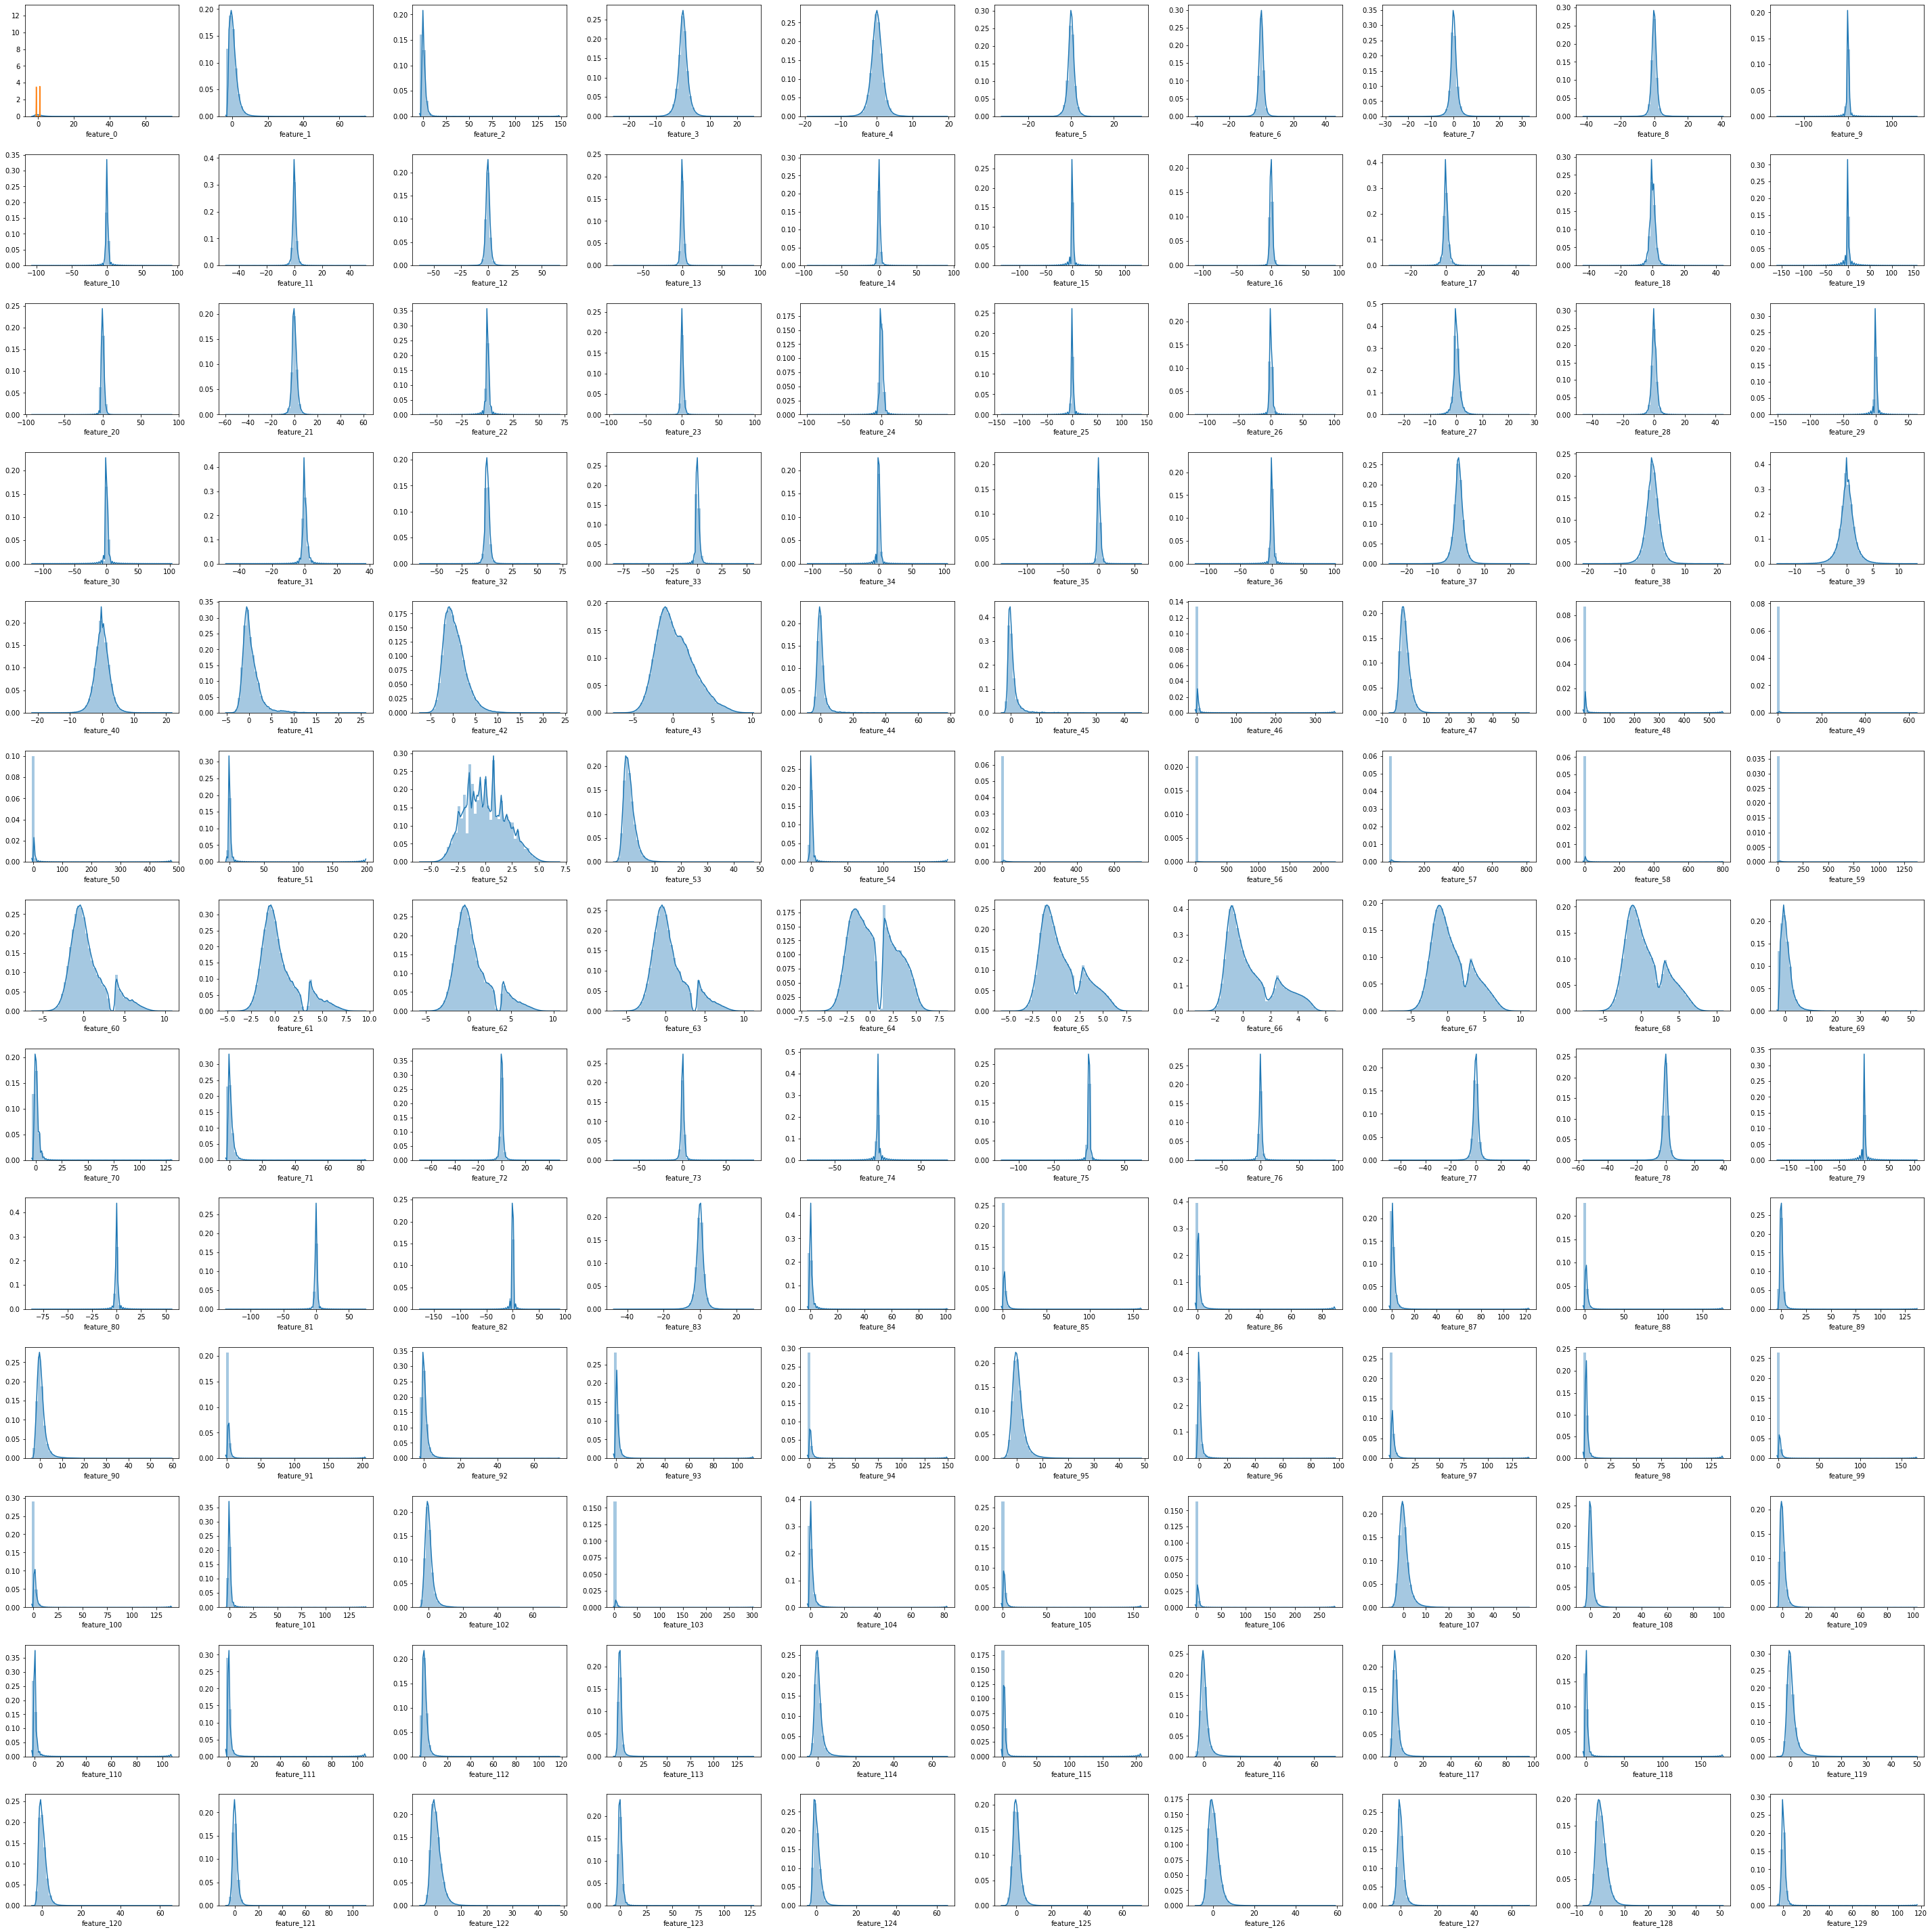

In [49]:
# Plotting (Do not run this, it takes long time)
fig, ax = plt.subplots(13,10, figsize = (52,40))
for i in range(13):
    for j in range(10):
        index = 10*i+j
        sns.distplot(df_train['feature_'+str(index)], ax = ax[i,j])
# visualization of distributions of features
fig.tight_layout(pad=2.0)
fig

In [52]:
# Visualization of the correlation matrix
df_train.corr().style.background_gradient(cmap='Spectral', axis=None).set_precision(2)

## Informations on daily returns and daily volumes
Note that the return was stable for a short while between 100 and 200 for some unknown reasons. 

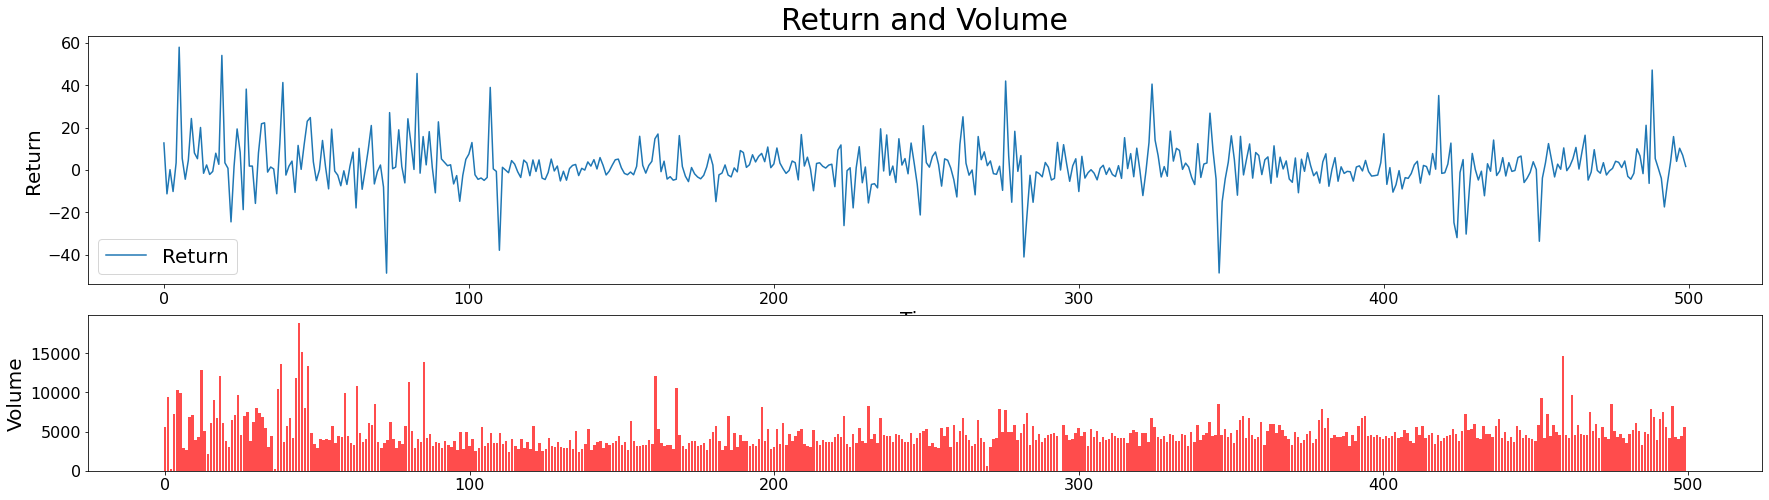

In [122]:
#Visualization: Daily Return vs Daily Volume

Volume = df_train.date
Volume = Volume.value_counts().sort_index()

daily_return = df_train[['date','resp']].groupby(['date']).sum()
daily_return

plt.rcParams["figure.figsize"] = (30,8)

ax_return = plt.subplot2grid((5,4),(0,0),rowspan = 3,colspan = 4)
ax_volumes = plt.subplot2grid((5,4),(3,0),colspan = 4,rowspan = 2)
ax_return.plot(daily_return.index, daily_return.resp, label = "Return")
ax_return.set_title("Return and Volume",fontsize = 30)
ax_return.legend(fontsize = 20)
ax_return.set_xlabel('Time',fontsize = 20)
ax_return.set_ylabel('Return',fontsize = 20)
ax_return.tick_params(axis = 'both',labelsize = 16)

plt.subplots_adjust(wspace = 0.5,hspace = 0.5)
ax_volumes.set_ylabel('Volume',fontsize = 20)
ax_volumes.bar(Volume.index, Volume, color = 'red',alpha = 0.7)
ax_volumes.tick_params(axis = 'both',labelsize = 16)


In [124]:
daily_return.describe()

resp
count  500.000000
mean     1.952129
std     11.085616
min    -48.649796
25%     -2.616761
50%      1.187239
75%      5.285396
max     57.957487

In [126]:
pd.DataFrame(Volume.describe())

date
count    500.000000
mean    4780.982000
std     2023.246691
min       29.000000
25%     3621.000000
50%     4353.500000
75%     5220.250000
max    18884.000000

## **Feature file info**
Each feature is consist of 28 tags  
No information in regards of tags are given.   
Some features are suspected to be duplicates since they have exactly the same tags structure.

In [7]:
df_feature = pd.read_csv('features.csv')

In [9]:
df_feature.head()

feature  tag_0  tag_1  tag_2  tag_3  tag_4  tag_5  tag_6  tag_7  tag_8  \
0  feature_0  False  False  False  False  False  False  False  False  False   
1  feature_1  False  False  False  False  False  False   True   True  False   
2  feature_2  False  False  False  False  False  False   True   True  False   
3  feature_3  False  False  False  False  False  False   True  False   True   
4  feature_4  False  False  False  False  False  False   True  False   True   

   ...  tag_19  tag_20  tag_21  tag_22  tag_23  tag_24  tag_25  tag_26  \
0  ...   False   False   False   False   False   False   False   False   
1  ...   False   False   False   False   False   False   False   False   
2  ...   False   False   False   False   False   False   False   False   
3  ...   False   False   False   False   False   False   False   False   
4  ...   False   False   False   False   False   False   False   False   

   tag_27  tag_28  
0   False   False  
1   False   False  
2   False   False  
3   False   False  
4   False   False  

[5 rows x 30 columns]

In [143]:
#Duplicated features
feature_dup = df_feature.drop(['feature'], axis = 1).duplicated(subset=None, keep='first')
feature_dup[feature_dup == True]

42    True
43    True
48    True
50    True
51    True
52    True
61    True
63    True
65    True
66    True
67    True
68    True
dtype: bool